In [1]:
import sys

sys.path.append('./source/')
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy.interpolate import interp1d
import importlib
import json

from source import plots
from source import prob_dists as pd
from source.utils import read_param_file


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# plots.p1_plot({})

In [3]:
# plots.p1_slope_plot({})

In [4]:
importlib.reload(pd)
n = -1

params = {'R_G': 220, # Kpc
          'd_solar': 8.5, # kpc
          'psi': 40,
          'M_min': 1.0e-2, # Msun
          'M_max': 1.0e10, # Msun
          'fwimp': 1.0,
          'mean_params': {'a':77.4, 'b':0.87+0.31*n, 'c':-0.23-0.04*n},
          'nside': 128,
          'area_fermi': 2000.0, # cm^2
          'n': n,
          'log_flux_min': -14, # log10 photons/cm^2/yr
          'log_flux_max': -5, # log10 photons/cm^2/yr
          'N': 1000,
          'log_k_min': 2,
          'log_k_max': 14,
          'N_k': 25000,
          'psh_log_f_min': -9,
          'psh_log_f_max': -4,
          'N_psh': 500
         }

params['omega_pixel'] = 4.*np.pi/(12*params['nside']**2.) # sr
p = params
# json.dump(p, open('source/n-1.params', 'w'), indent=0)

In [2]:
p = read_param_file('source/n-1.params')
p

{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.1,
 'M_max': 10000000000.0,
 'fwimp': 0.01169695,
 'mean_params': {'a': 77.4, 'b': 0.56, 'c': -0.19},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': -1,
 'log_flux_min': -16,
 'log_flux_max': -2,
 'N': 2200,
 'log_k_min': 0,
 'log_k_max': 10,
 'N_k': 250000,
 'psh_log_f_min': -8,
 'psh_log_f_max': -3.0,
 'N_psh': 1000,
 'omega_pixel': 6.391586616190171e-05,
 'exposure': 5570.423008216337,
 'iso_flux_bg': 0.0008615905978150363,
 'gal_flux_bg_file': './output/gal_flux_bg.npy',
 'bg': 1,
 'beg': 1,
 'beta': 1.9}

In [38]:
p['beta'] = 1.57
p['fwimp'] = 0.011696 * 9.029751204381899
p['nside'] = 2048
p['omega_pixel'] = 4.*np.pi/(12*p['nside']**2.) # sr
p['M_min'] = 2.13
p['N_k'] = 90000
p['N'] = 5000
p['psi'] = 100
p['log_k_max'] = 12
p['log_k_min'] = 0
p['psh_log_f_min'] = -9
p['psh_log_f_max'] = -4
p['log_flux_min'] = -13
p['log_flux_max'] = -1

beta is 1.57


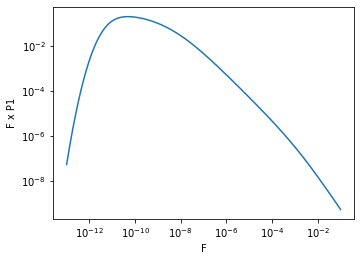

In [39]:
fluxes = np.logspace(p['log_flux_min'], p['log_flux_max'], num=p['N'])
p1_vals = pd.p1(fluxes, **p)
fig, _ = plots.check_fp1_plot(fluxes, p1_vals)

beta is 1.57
[43.30057258]


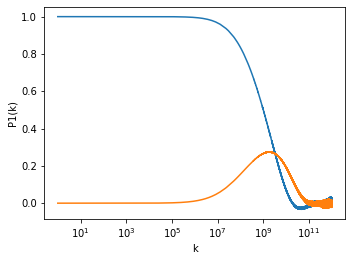

In [40]:
muu = pd.mu(**p)
print(muu)
# muu = 1
ft_p1_vals, k = pd.ft_p1(p1_vals, fluxes, **p)
fig, _ = plots.check_ft_p1_plot(k, ft_p1_vals)


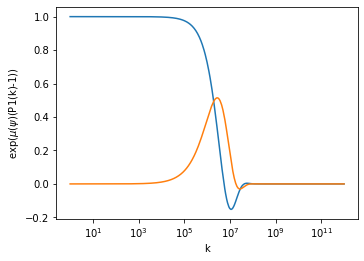

In [41]:
fig, _ = plots.check_psh_integrand_plot(k, ft_p1_vals, muu)

In [42]:
pf_vals, flux = pd.pf(muu, ft_p1_vals - np.exp(-muu), k, **p)

(1e-08, 1)

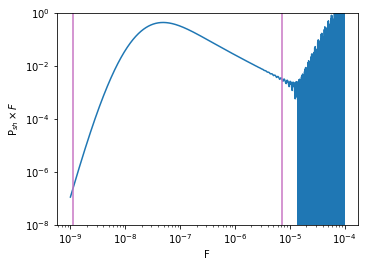

In [43]:
startl = 10
limi = -230
fig, ax = plots.check_psh_plot(flux, pf_vals, j=[startl, limi])
ax.set_ylim(top=1, bottom=1e-8)

In [44]:
print(f'\mu \int F P1: {(muu * integrate.simps(fluxes * p1_vals, fluxes))}')
print(f' \int F Psh: {integrate.simps(pf_vals[startl:limi].real * flux[startl:limi], flux[startl:limi])}')

np.savez('./output/psh_degeneracy_som.npz', fluxes=flux[startl:limi], psh=pf_vals[startl:limi].real)

\mu \int F P1: [2.78304899e-07]
 \int F Psh: 1.494019943497367e-07


In [12]:
np.save(f'./som_trial/trial_{p["N"]}_{p["N_k"]}.npy', pf_vals)

ValueError: x and y must have same first dimension, but have shapes (1000,) and (500,)

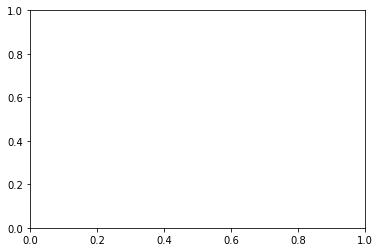

In [13]:
import glob
files = glob.glob('./som_trial/*.npy')
fig, ax = plt.subplots()
for fil in files:
    dat = np.load(fil)
    ax.plot(flux, dat, label=fil.strip('.npy').split('/')[-1])
    
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
fig

In [ ]:
pshvals, fxs = pd.psh(params, plot=True, infer_values=True)

In [ ]:
plt.plot(fxs, fxs * pshvals.real)
ax = plt.gca()
startl = 0
limi = -1
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(fxs[startl], color='b')
ax.axvline(fxs[limi], color='b')

print(f' \int F Psh: {integrate.simps(pshvals[startl:limi].real * fxs[startl:limi], fxs[startl:limi])}')


In [ ]:
numnum = 5
psis = np.linspace(40, 90, num=numnum)
colors = cm.viridis(np.linspace(0, 1, num=numnum))

fig, ax = plt.subplots()

psh_vals_over_psi = []

for psi, col in zip(psis, colors):
    p['psi'] = psi
    print('Angle:', psi)
    pshvals, fxs = pd.psh(params, plot=True, infer_values=True)
    
    psh_vals_over_psi.append((pshvals, fxs))
    
    ax.plot(fxs, fxs * pshvals.real, label=rf"{psi}$^\circ$", color=col)
   
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('F')
ax.set_ylabel('F x Psh')
cbarlabs = np.arange(min(psis), max(psis)+1, step=10)
cbar = fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ticks=np.linspace(0, 1, num=len(cbarlabs)))
cbar.set_label(r'$\psi$[$^\circ$]', rotation=270)
cbar.ax.set_yticklabels(cbarlabs)

In [ ]:
fig
fig.savefig('./output/psh_n-1.png')

In [ ]:
fig